In [1]:
import pandas as pd
import numpy as np  
import torch 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from xgboost import XGBClassifier
import json
import matplotlib.pyplot as plt


In [63]:
df = pd.read_csv("combined_league_matches.csv")
#Some useful stuff we might wanna use
champion_ids = [col for col in df.columns if 'champion' in col]
all_games = pd.concat([df[col] for col in champion_ids]) 
games_per_champ = all_games.value_counts() #maybe useful, find total number of games per champ id

Basic Random Forest

In [3]:
df = pd.read_csv("combined_league_matches.csv")

encoder = LabelEncoder()

for col in ['red_champion_0', 'red_champion_1', 'red_champion_2', 'red_champion_3', 'red_champion_4',
            'blue_champion_0', 'blue_champion_1', 'blue_champion_2', 'blue_champion_3', 'blue_champion_4']:
    df[col] = encoder.fit_transform(df[col])

df['target'] = df['winner'].apply(lambda x: 1 if x == 'blue' else 0) #blueside win if 1
df = df.drop(columns=['match_id', 'winner'])

#if we want to test without mastery just uncomment below
#df = df.drop(columns=['red_mastery_0', 'red_mastery_1', 'red_mastery_2', 'red_mastery_3', 'red_mastery_4',
#            'blue_mastery_0', 'blue_mastery_1', 'blue_mastery_2', 'blue_mastery_3', 'blue_mastery_4'])


In [4]:
X = df.drop(columns=['target'])  # Features (character data)
y = df['target']  # win/loss from blue perspective

In [5]:
#splitting data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #can use random_state

In [67]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [68]:
model = RandomForestClassifier()#can use random_state
randomizedModel = RandomizedSearchCV(estimator = model, param_distributions= random_grid, n_iter=100, random_state=100,n_jobs=1)
randomizedModel.fit(X_train, y_train)


# to see best parameters
randomizedModel.best_params_

# to make new classifier with the best estimator
best_random_grid = randomizedModel.best_estimator_
best_random_grid.fit(X_train, y_train)

#Predict
y_pred = best_random_grid.predict(X_test)

#Eval
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

Trying to scale the mastery levels and using random forest

0.5671091445427728
              precision    recall  f1-score   support

           0       0.60      0.25      0.35      1282
           1       0.56      0.86      0.68      1430

    accuracy                           0.57      2712
   macro avg       0.58      0.55      0.51      2712
weighted avg       0.58      0.57      0.52      2712



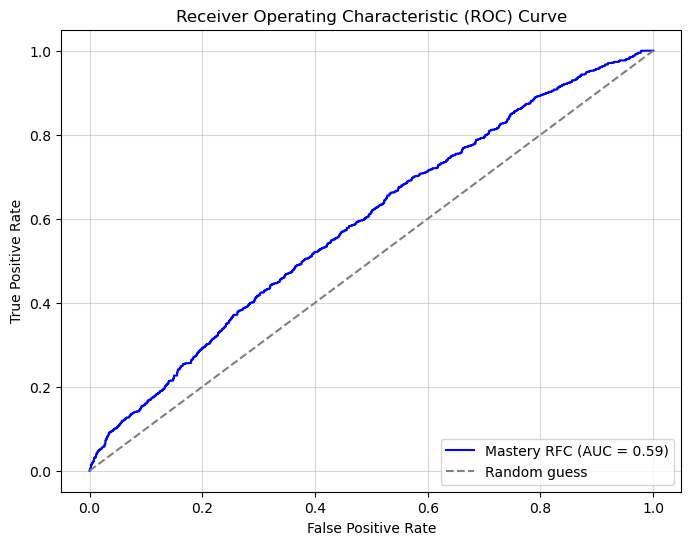

In [10]:
#randomizedModel.best_params_
model = RandomForestClassifier(n_estimators= 600, min_samples_split= 5, min_samples_leaf= 1, max_features= 'sqrt', max_depth=10, criterion='gini')
model.fit(X_train, y_train)

#Predict
y_pred = model.predict(X_test)

#Eval
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred))

y_prob = model.predict_proba(X_test)[:, 1]  

fpr0, tpr0, thresholds0 = roc_curve(y_test, y_prob)
roc_auc0 = roc_auc_score(y_test, y_prob)


In [11]:
df = pd.read_csv("combined_league_matches.csv")
champion_ids = [col for col in df.columns if 'champion' in col]
all_games = pd.concat([df[col] for col in champion_ids]) 
games_per_champ = all_games.value_counts() #maybe useful, find total number of games per champ id


encoder = LabelEncoder()

for col in ['red_champion_0', 'red_champion_1', 'red_champion_2', 'red_champion_3', 'red_champion_4',
            'blue_champion_0', 'blue_champion_1', 'blue_champion_2', 'blue_champion_3', 'blue_champion_4']:
    df[col] = encoder.fit_transform(df[col])

df['target'] = df['winner'].apply(lambda x: 1 if x == 'blue' else 0) #blueside win if 1
df = df.drop(columns=['match_id', 'winner'])

#if we want to test without mastery just uncomment below
#df = df.drop(columns=['red_mastery_0', 'red_mastery_1', 'red_mastery_2', 'red_mastery_3', 'red_mastery_4',
#            'blue_mastery_0', 'blue_mastery_1', 'blue_mastery_2', 'blue_mastery_3', 'blue_mastery_4'])

#scale all mastery values
mastery_columns = [
    'red_mastery_0', 'red_mastery_1', 'red_mastery_2', 'red_mastery_3', 'red_mastery_4',
    'blue_mastery_0', 'blue_mastery_1', 'blue_mastery_2', 'blue_mastery_3', 'blue_mastery_4'
]

scaler = StandardScaler() #can also try minmaxscaler and keep within certain range

df[mastery_columns] = scaler.fit_transform(df[mastery_columns])

0.5789085545722714
              precision    recall  f1-score   support

           0       0.60      0.27      0.37      1258
           1       0.57      0.85      0.68      1454

    accuracy                           0.58      2712
   macro avg       0.59      0.56      0.53      2712
weighted avg       0.59      0.58      0.54      2712



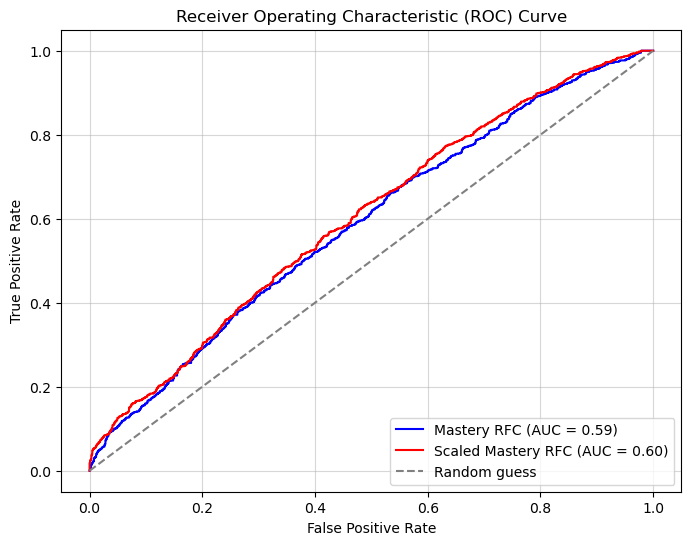

In [12]:
X = df.drop(columns=['target'])
y = df['target']

# Split the data and proceed with model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model = RandomForestClassifier(n_estimators= 600, min_samples_split= 5, min_samples_leaf= 1, max_features= 'sqrt', max_depth=10, criterion='gini')
model.fit(X_train, y_train)

#Predict
y_pred = model.predict(X_test)

#Eval
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred))

y_prob = model.predict_proba(X_test)[:, 1]  

fpr1, tpr1, thresholds1 = roc_curve(y_test, y_prob)
roc_auc1 = roc_auc_score(y_test, y_prob)

#Using mean Winrate

Accuracy: 0.5664761202286557
Confusion Matrix:
 [[ 733 1834]
 [ 517 2339]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.29      0.38      2567
           1       0.56      0.82      0.67      2856

    accuracy                           0.57      5423
   macro avg       0.57      0.55      0.52      5423
weighted avg       0.57      0.57      0.53      5423



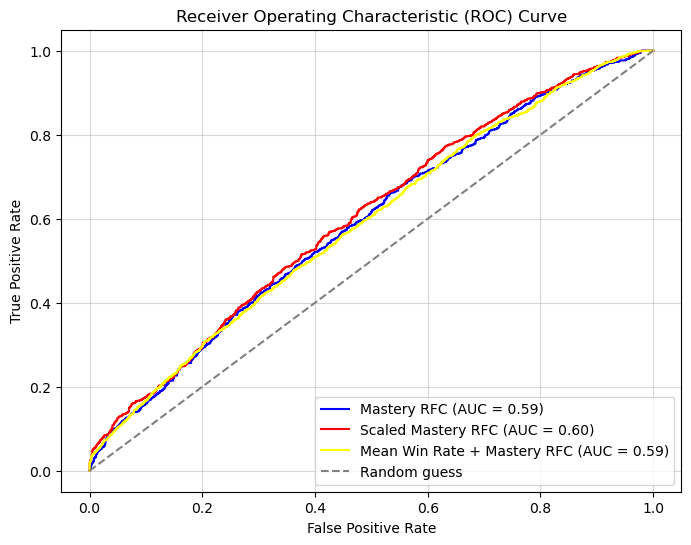

In [14]:
df = pd.read_csv("combined_league_matches.csv")

df['target'] = df['winner'].apply(lambda x: 1 if x == 'blue' else 0) #blueside win if 1
df = df.drop(columns=['match_id', 'winner'])

with open("champions_with_mean_winrate.json", "r") as file:
    win_rate_data = json.load(file)
win_rates = {int(k): float(v.strip('%')) for k, v in win_rate_data.items()}

for col in df.columns:
    if "champion" in col:
        df[col] = df[col].map(win_rates)

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

y_prob = model.predict_proba(X_test)[:, 1]  

fpr2, tpr2, thresholds2 = roc_curve(y_test, y_prob)
roc_auc2 = roc_auc_score(y_test, y_prob)

#Using mean with outlier replaced winrate

Accuracy: 0.5644477226627328
Confusion Matrix:
 [[ 670 1888]
 [ 474 2391]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.26      0.36      2558
           1       0.56      0.83      0.67      2865

    accuracy                           0.56      5423
   macro avg       0.57      0.55      0.52      5423
weighted avg       0.57      0.56      0.52      5423



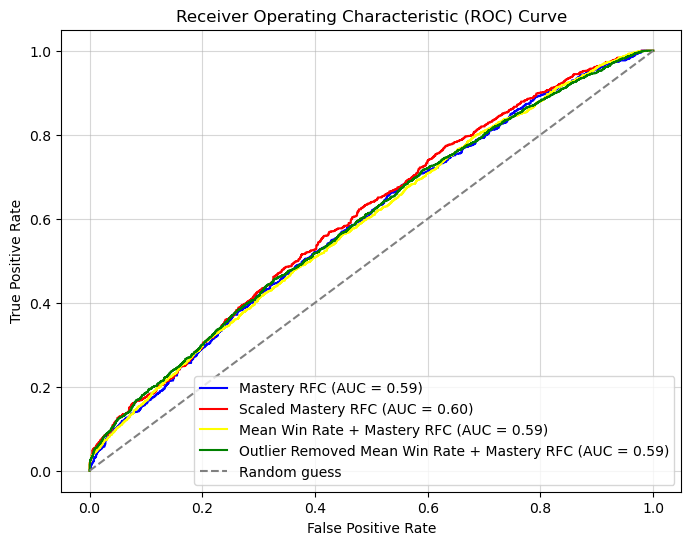

In [17]:
df = pd.read_csv("combined_league_matches.csv")

df['target'] = df['winner'].apply(lambda x: 1 if x == 'blue' else 0) #blueside win if 1
df = df.drop(columns=['match_id', 'winner'])

with open("outlier_removed_champion_winrates.json", "r") as file:
    win_rate_data = json.load(file)
win_rates = {int(k): float(v) for k, v in win_rate_data.items()}
for col in df.columns:
    if "champion" in col:
        df[col] = df[col].map(win_rates)

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

y_prob = model.predict_proba(X_test)[:, 1]  

fpr3, tpr3, thresholds3 = roc_curve(y_test, y_prob)
roc_auc3 = roc_auc_score(y_test, y_prob)


Accuracy: 0.5624193250968099
Confusion Matrix:
 [[ 723 1876]
 [ 497 2327]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.28      0.38      2599
           1       0.55      0.82      0.66      2824

    accuracy                           0.56      5423
   macro avg       0.57      0.55      0.52      5423
weighted avg       0.57      0.56      0.53      5423



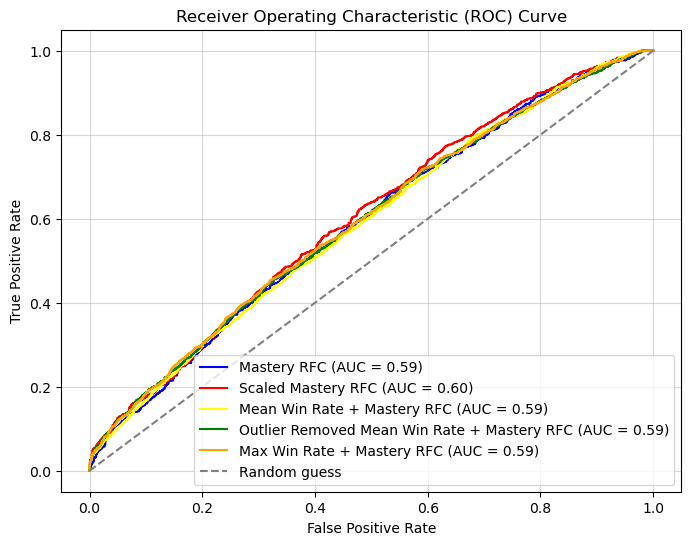

In [19]:
df = pd.read_csv("combined_league_matches.csv")

df['target'] = df['winner'].apply(lambda x: 1 if x == 'blue' else 0) #blueside win if 1
df = df.drop(columns=['match_id', 'winner'])

with open("champion_max_winrates.json", "r") as file:
    win_rate_data = json.load(file)
win_rates = {int(k): float(v) for k, v in win_rate_data.items()}

for col in df.columns:
    if "champion" in col:
        df[col] = df[col].map(win_rates)

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

y_prob = model.predict_proba(X_test)[:, 1]  

fpr4, tpr4, thresholds4 = roc_curve(y_test, y_prob)
roc_auc4 = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr0, tpr0, color='blue', label=f'Mastery RFC (AUC = {roc_auc0:.2f})')
plt.plot(fpr1, tpr1, color='red', label=f'Scaled Mastery RFC (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='yellow', label=f'Mean Win Rate + Mastery RFC (AUC = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, color='green', label=f'Outlier Removed Mean Win Rate + Mastery RFC (AUC = {roc_auc3:.2f})')
plt.plot(fpr4, tpr4, color='orange', label=f'Max Win Rate + Mastery RFC (AUC = {roc_auc4:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()